In [1]:
library(sits)
set.seed(123)

SITS - satellite image time series analysis.

Loaded sits v1.5.1.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.



### Create cube

In [2]:
Sys.setenv("PROJ_LIB"="/usr/share/proj")

In [3]:
#
# General definitions
#

# Dates
y <- "2022"

# Cube directory
cube_dir <- "../data/output/PE/cube/"

# Bands
cube_bands <- c(
  "B02", "B03", "B04", "B08", "B11", "B12", "B8A", "EVI", "NDVI", "CLOUD"
)

# Hardware - multicores
multicores <- 24

#
# 1. Create cube directory
#
dir.create(cube_dir, recursive = TRUE)

#
# 2. Read ROI
#
tile <- c("035015", "036015", "036016")

#
# 3. Generate cubes
#
# define dates
start_date <- paste0("2021-10-01")
end_date <- paste0("2022-09-30")

# load cube
cube <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    tiles      = tile,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

  |======================================================================| 100%


In [4]:
print(cube)

# A tibble: 3 × 12
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    SENTINEL-2-16D SENTINEL… MSI    0350… 6.32e6 6.43e6 1.03e7 1.04e7 "PRO…
2 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.03e7 1.04e7 "PRO…
3 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.02e7 1.03e7 "PRO…
# ℹ 2 more variables: labels <list>, file_info <list>


### Reading Samples

In [5]:
#
# General definition
#

# Samples
samples_file <- "../data/output/PE/time_series/clean_samples_2019_2020_band.rds"

# Output directory
base_output_dir <- "../data/output/PE"

#
# 1. Load samples
#
samples <- readRDS(samples_file)

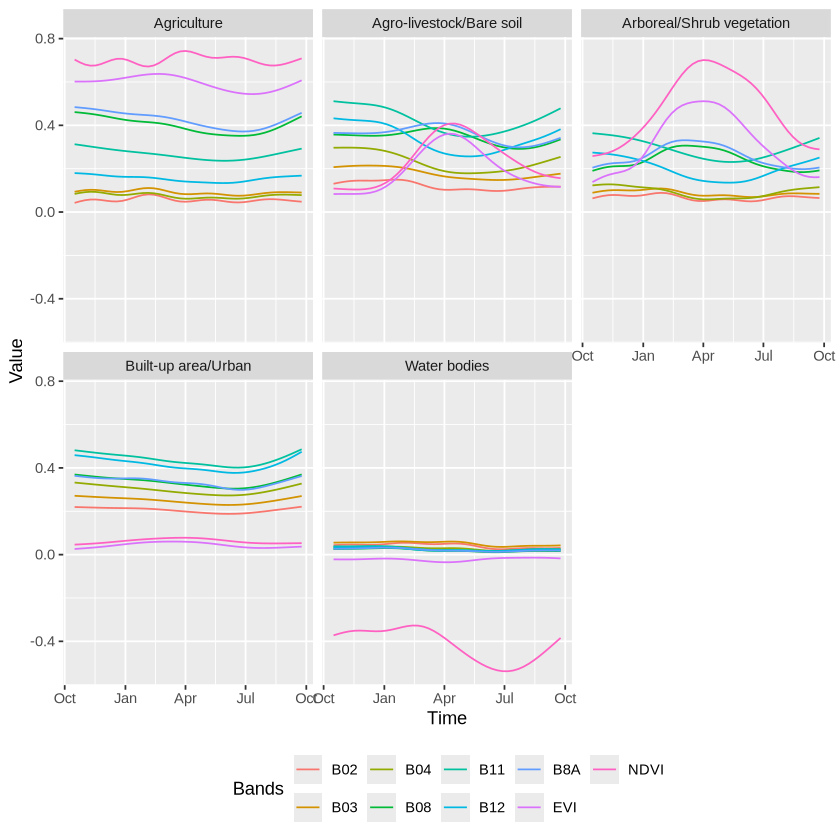

In [6]:
plot(sits_patterns(samples))

### Tunning CNN

In [7]:
#
# 2. Train model
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%


In [8]:
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.989 0.986 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 2    0.989 0.986 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.989 0.986 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 4    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 6    0.984 0.979 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 7    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 8    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 9    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(5, 5, 5) 
10    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

In [10]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_pe.rds"))

Warning message in dir.create(tuning_dir, recursive = TRUE):
“'../data/output/PE/tune/tempcnn' already exists”


In [11]:
tuned_tempcnn <- readRDS("../data/output/PE/tune/tempcnn/tempcnn_pe.rds")

### Training CNN

In [13]:
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^6, 2^6, 2^6),
          cnn_kernels = c(7, 7, 7),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.0003105814),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [14]:
environment(tcnn_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 8.6s
• Avg time per training epoch: 219ms

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.0584
acc: 0.9872

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 440,837 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• conv_bn_relu1: <conv1D_batch_norm

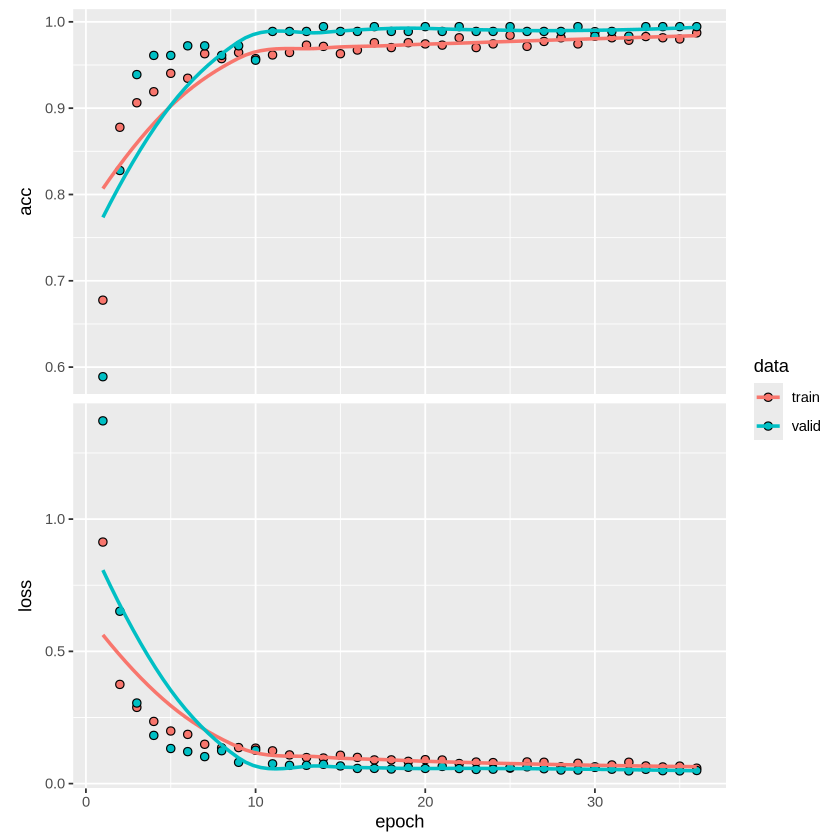

In [15]:
plot(tcnn_model)

In [16]:
#
# 3. Save model
#

base_model_dir <- "../data/output/PE/model/"

tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

# create directory
dir.create(base_model_dir, recursive = TRUE)

# save
saveRDS(tcnn_model, tcnn_dir)

In [17]:
tcnn_model <- readRDS("../data/output/PE/model/tcnn_model.rds")

### Tuning LightTAE

In [18]:
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%

ERROR: Error in .check_remote_errors(val): 36 nodes produced errors; first error: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.76 GiB total capacity; 231.24 MiB already allocated; 1.25 MiB free; 330.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Exception raised from malloc at ../c10/cuda/CUDACachingAllocator.cpp:936 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >) + 0x6b (0x766e7325a6bb in /opt/conda/lib/R/library/torch/lib/libc10.so)
frame #1: <unknown function> + 0x2f176 (0x766e7262f176 in /opt/conda/lib/R/library/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x2fc12 (0x766e7262fc12 in /opt/conda/lib/R/library/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x3009e (0x766e7263009e in /opt/conda/lib/R/library/torch/lib/libc10_cuda.so)
frame #4: <unknown function> + 0x136e33c (0x766e5b36e33c in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #5: at::detail::empty_generic(c10::ArrayRef<long>, c10::Allocator*, c10::DispatchKeySet, c10::ScalarType, c10::optional<c10::MemoryFormat>) + 0x23 (0x766e5b366f23 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #6: at::detail::empty_cuda(c10::ArrayRef<long>, c10::ScalarType, c10::optional<c10::Device>, c10::optional<c10::MemoryFormat>) + 0x97 (0x766e045d09a7 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #7: at::detail::empty_cuda(c10::ArrayRef<long>, c10::optional<c10::ScalarType>, c10::optional<c10::Layout>, c10::optional<c10::Device>, c10::optional<bool>, c10::optional<c10::MemoryFormat>) + 0x40 (0x766e045d0b60 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #8: at::native::empty_cuda(c10::ArrayRef<long>, c10::optional<c10::ScalarType>, c10::optional<c10::Layout>, c10::optional<c10::Device>, c10::optional<bool>, c10::optional<c10::MemoryFormat>) + 0x33 (0x766e046f1b13 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0x2dce00b (0x766e061ce00b in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #10: <unknown function> + 0x2dce158 (0x766e061ce158 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #11: at::_ops::empty_memory_format::redispatch(c10::DispatchKeySet, c10::ArrayRef<c10::SymInt>, c10::optional<c10::ScalarType>, c10::optional<c10::Layout>, c10::optional<c10::Device>, c10::optional<bool>, c10::optional<c10::MemoryFormat>) + 0x1c7 (0x766e5c2c14d7 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x25fa368 (0x766e5c5fa368 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #13: at::_ops::empty_memory_format::call(c10::ArrayRef<c10::SymInt>, c10::optional<c10::ScalarType>, c10::optional<c10::Layout>, c10::optional<c10::Device>, c10::optional<bool>, c10::optional<c10::MemoryFormat>) + 0x15f (0x766e5c2fa8cf in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x11ee2db (0x766e045ee2db in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #15: <unknown function> + 0x30ae378 (0x766e064ae378 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0x30df50a (0x766e064df50a in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0x2dc6cc1 (0x766e061c6cc1 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #18: <unknown function> + 0x2dc6d80 (0x766e061c6d80 in /opt/conda/lib/R/library/torch/lib/libtorch_cuda.so)
frame #19: at::_ops::addmm::redispatch(c10::DispatchKeySet, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 0xab (0x766e5bfaea1b in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0x3a753e4 (0x766e5da753e4 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #21: <unknown function> + 0x3a76182 (0x766e5da76182 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #22: at::_ops::addmm::call(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar const&, c10::Scalar const&) + 0x1b1 (0x766e5c0134a1 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #23: at::native::linear(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 0x3b4 (0x766e5b8612d4 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #24: <unknown function> + 0x29ab8b6 (0x766e5c9ab8b6 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #25: at::_ops::linear::call(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 0x196 (0x766e5bffd346 in /opt/conda/lib/R/library/torch/lib/libtorch_cpu.so)
frame #26: at::linear(at::Tensor const&, at::Tensor const&, c10::optional<at::Tensor> const&) + 0x43 (0x766e742da315 in /opt/conda/lib/R/library/torch/lib/liblantern.so)
frame #27: _lantern_linear_tensor_tensor_tensor + 0x143 (0x766e73e37bfe in /opt/conda/lib/R/library/torch/lib/liblantern.so)
frame #28: cpp_torch_namespace_linear_input_Tensor_weight_Tensor(XPtrTorchTensor, XPtrTorchTensor, XPtrTorchOptionalTensor) + 0x41 (0x766e74f4e171 in /opt/conda/lib/R/library/torch/libs/torchpkg.so)
frame #29: _torch_cpp_torch_namespace_linear_input_Tensor_weight_Tensor + 0x9f (0x766e74cbe1af in /opt/conda/lib/R/library/torch/libs/torchpkg.so)
frame #30: <unknown function> + 0x10439e (0x766f4e47639e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #31: <unknown function> + 0x1475ba (0x766f4e4b95ba in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #32: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #33: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #34: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #35: Rf_eval + 0x2b1 (0x766f4e4cf361 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #36: <unknown function> + 0xcbe05 (0x766f4e43de05 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #37: <unknown function> + 0x1437e1 (0x766f4e4b57e1 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #38: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #39: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #40: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #41: <unknown function> + 0x14b53a (0x766f4e4bd53a in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #42: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #43: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #44: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #45: <unknown function> + 0x14b53a (0x766f4e4bd53a in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #46: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #47: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #48: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #49: <unknown function> + 0x14b53a (0x766f4e4bd53a in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #50: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #51: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #52: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #53: <unknown function> + 0x14b53a (0x766f4e4bd53a in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #54: Rf_eval + 0x80 (0x766f4e4cf130 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #55: <unknown function> + 0x15f380 (0x766f4e4d1380 in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #56: Rf_applyClosure + 0x19e (0x766f4e4d214e in /opt/conda/lib/R/bin/exec/../../lib/libR.so)
frame #57: Rf_eval + 0x2b1 (0x766f4e4cf361 in /opt/conda/lib/R/bin/exec/../.


In [14]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/lighttae/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_pe.rds"))

In [3]:
tuned_lighttae <- readRDS("../data/output/PE/tune/lighttae/lighttae_pe.rds")

In [25]:
print(tuned_lighttae[1,]$opt_hparams)

[[1]]
# A tibble: 1 × 2
       lr weight_decay
    <dbl>        <dbl>
1 0.00147     0.000246



### Training LightTAE

In [27]:
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.00147, weight_decay = 0.000246),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [32]:
environment(lighttae_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 1m 29.8s
• Avg time per training epoch: 1.5s

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.1252
acc: 0.9643

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 127,867 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• spatial_encoder: <torch_pixel_

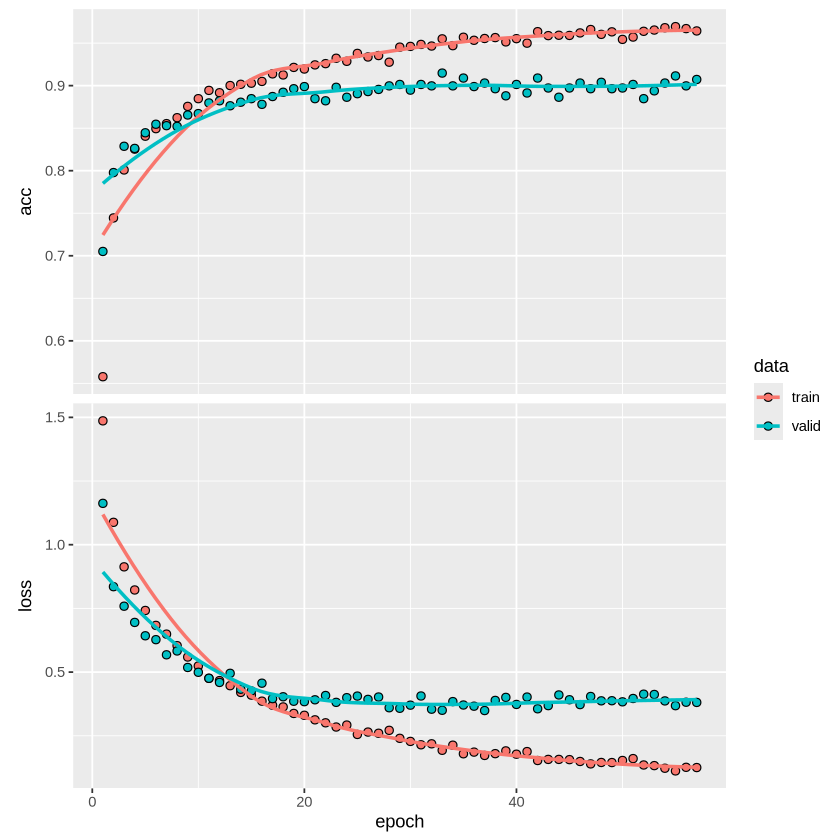

In [28]:
plot(lighttae_model)

In [29]:
#
# 3. Save model
#

ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

# save
saveRDS(lighttae_model, ltae_dir)

In [7]:
lighttae_model <- readRDS("../data/output/PE/model/ltae_model.rds")

### Pixel-based classification - TCNN

In [35]:
# Output directory
output_dir <- "../data/output/PE/classifications/tccn"

# Version
results_version <- "tcnn-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#

# classify
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/classifications/tccn' already exists”
using blocks of size 1024 x 7040

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-03 14:55:44.473776

elapsed time for task0.01 secs



  |======================================================================| 100%


### Pixel-based classification - LightTAE

In [36]:
# Output directory
output_dir <- "../data/output/PE/classifications/lighttae"

# Version
results_version <- "lighttaeb-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

using blocks of size 1024 x 7040

Starting classification of tile '006008' at 2024-12-03 15:08:31.714206



  |======================================================================| 100%


Tile '006008' finished at 2024-12-03 15:24:42.58268

Elapsed time of 16.18 mins





task finished at2024-12-03 15:24:42.78521

elapsed time for task16.18 mins



  |======================================================================| 100%


### Apply Spatial-temporal segmentation

In [4]:
segment_dir <- "../data/output/PE/segment/"
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

recovery mode: data already exists. To produce new data, change output_dir or version



### Object-based classification - TCNN

In [10]:
# Output directory
output_dir <- "../data/output/PE/segment/tcnn"

# Version
results_version <- "tcnn-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments_20LMR,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/RO/segment/tcnn' already exists”


  |                                                                      |   0%

Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==========                                                            |  14%

Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |====================                                                  |  29%

Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==============================                                        |  43%

Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |========================================                              |  57%

Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==================================================                    |  71%

Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |============================================================          |  86%

Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |======================================================================| 100%


In [14]:
plot(class_cube)

Warning message in .colors_get(labels = labels, legend = legend, palette = palette, :
“missing colors for labelsForest2, wetlands2, Burned_Areas, Forests4”
Warning message in .colors_get(labels = labels, legend = legend, palette = palette, :
“palette for missing colors isSpectral”


ERROR: Error in utils::packageVersion("tmap"): there is no package called ‘tmap’


### Object-based classification - LightTae

In [ ]:
# Output directory
output_dir <- "../data/output/PE/segment/ltae"

# Version
results_version <- "ltae-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/RO/segment/ltae' already exists”
Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
